In [1]:
from convokit import Corpus
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
corpus = Corpus(filename='Wikipedia-Disputes-Corpus')

In [4]:
analyzer = SentimentIntensityAnalyzer()

In [5]:
for utt in corpus.iter_utterances():
    utt.meta['vader'] = analyzer.polarity_scores(utt.text)
    utt.meta['compound'] = utt.meta['vader']['compound']

From https://github.com/cjhutto/vaderSentiment, 

"The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate."

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05


## Feature annotation

We can't do topic features since they were not included in the data, nor can we include 'num_revisions' in the discussion_feats.

In [60]:
from convokit import BoWTransformer, VectorClassifier, Classifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

### Discussion features

In [21]:
for convo in corpus.iter_conversations():
    discussion_feats = dict()
    discussion_feats['num_turns'] = len(list(convo.iter_utterances())) 
    discussion_feats['num_participants'] = len(set(list(convo.iter_speakers())))
    discussion_feats['avg_num_words_per_turn'] = sum([len(utt.text.split(' ')) for utt in convo.iter_utterances()]) / discussion_feats['num_turns']
    convo.meta['discussion_feats'] = discussion_feats

In [32]:
corpus.random_conversation().meta['page_name']

'Discussion:Transcendental Meditation_Archive 12'

In [20]:
discussion_feats

{'num_turns': 15,
 'num_participants': 9,
 'avg_num_words_per_turn': 31.533333333333335}

In [61]:
model = Pipeline([("standardScaler", StandardScaler(with_mean=False)),
                            ("logreg", LogisticRegression(solver='liblinear'))])
clf = Classifier(obj_type='conversation', pred_feats=['discussion_feats'], 
                 labeller=lambda convo: convo.meta['has_dispute'], clf=model)

In [62]:
res = clf.evaluate_with_cv(corpus)

Using corpus objects...
Running a cross-validated evaluation...
Done.


In [63]:
np.mean(res)

0.6634987320582889

In [69]:
clf.fit(corpus)

In [70]:
clf.get_coefs(feature_names=['num_turns', 'num_participants', 'avg_num_words_per_turn'])

,coef
feat_name,
num_turns,1.480032
avg_num_words_per_turn,0.576046
num_participants,0.350013


### Lexical features

In [50]:
from convokit import BoWTransformer, VectorClassifier
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [39]:
cv = CountVectorizer(min_df=10, max_df=.5, ngram_range=(1, 2),
                     binary=False, max_features=15000)

In [40]:
bow_transformer = BoWTransformer(obj_type='conversation', vectorizer=cv)

In [42]:
bow_transformer.fit_transform(corpus)

In [71]:
vclf = VectorClassifier(obj_type='conversation', labeller=lambda convo: convo.meta['has_dispute'], vector_name='bow_vector')

Initialized default classification model (standard scaled logistic regression).


In [74]:
res = vclf.evaluate_with_cv(corpus)
print(res)
print(np.mean(res))

Running a cross-validated evaluation...Done.
[0.80193906 0.80401662 0.79293629 0.80526681 0.79279279]
0.7993903129637202


In [78]:
vclf.fit(corpus)

In [79]:
vclf.get_coefs(feature_names=corpus.get_vector_matrix('bow_vector').columns)

,coef
feat_name,
for comment,0.863760
request for,0.851167
request,0.481580
for comments,0.407265
rfc,0.327475
an rfc,0.259022
rfc is,0.218804
sockpuppet,0.210076
statements by,0.208874


### Sentiment features

- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

In [84]:
from collections import defaultdict

In [81]:
def output_sentiment_labels(compound_score):
    if compound_score <= -0.05:
        return (False, False, True)
    elif compound_score >= 0.05:
        return (True, False, False)
    else:
        return (False, True, False)

In [82]:
for utt in corpus.iter_utterances():
    utt.meta['positive'], utt.meta['neutral'], utt.meta['negative'] = output_sentiment_labels(utt.meta['compound'])

#### Sentiment flow

In [83]:
def get_label(utt):
    if utt.meta['positive']: return 'positive'
    if utt.meta['negative']: return 'negative'
    if utt.meta['neutral']: return 'neutral'

In [179]:
valences = ['positive', 'negative', 'neutral']

In [180]:
from itertools import product

In [183]:
def compute_sentiment_flow(ordered_utts):
    retval = dict()
    num_pos, num_neu, num_neg = 0, 0, 0
    for utt in ordered_utts:
        if utt.meta['positive']:
            num_pos += 1
        elif utt.meta['negative']:
            num_neg += 1
        else:
            num_neu += 1
            
    total = num_pos + num_neg + num_neu
    retval['num_positive'], retval['num_neutral'], retval['num_negative'] = num_pos, num_neu, num_neg
    retval['prob_positive'], retval['pos_neutral'], retval['pos_negative'] = num_pos / total, num_neu / total, num_neg / total

    
    transitions = {f'{source}->{sink}': 0 for source, sink in product(valences, valences)}
    prev_utt = ordered_utts[0]
    for utt in ordered_utts[1:]:
        transitions[f'{get_label(prev_utt)}->{get_label(utt)}'] += 1
        prev_utt = utt
        
    total_trans = len(ordered_utts) - 1
    for trans, cnt in transitions.items():
        retval['prob_{}'.format(trans)] = cnt / total_trans
    return retval

In [184]:
import math
for convo in corpus.iter_conversations():
    utts = list(convo.iter_utterances())
    num_utts = len(utts)
    third_size = math.ceil(num_utts / 3)
    convo.meta['global_sentiment'] = {'global_' + k: v for k, v in compute_sentiment_flow(utts).items()}
    convo.meta['1st_third_sentiment'] = {'1/3_' + k: v for k, v in compute_sentiment_flow(utts[:third_size]).items()}
    convo.meta['2nd_third_sentiment'] = {'2/3_' + k: v for k, v in compute_sentiment_flow(utts[third_size:2*third_size]).items()}
    convo.meta['3rd_third_sentiment'] = {'3/3_' + k: v for k, v in compute_sentiment_flow(utts[2*third_size:]).items()}

In [186]:
sentiment_clf = Classifier(obj_type='conversation', pred_feats=['global_sentiment', 
                                                                '1st_third_sentiment', 
                                                                '2nd_third_sentiment',
                                                                '3rd_third_sentiment'
                                                               ], labeller=lambda convo: convo.meta['has_dispute'])

In [188]:
res = sentiment_clf.evaluate_with_cv(corpus, )
print(res)
print(np.mean(res))

Using corpus objects...
Running a cross-validated evaluation...
Done.
[0.59556787 0.5567867  0.72783934 0.75190575 0.77200277]
0.6808204859451397


In [13]:
import seaborn as sns
from collections import Counter

In [14]:
ctr = Counter(convo_lens)

In [16]:
{k: ctr[k] for k in sorted(ctr)}

{10: 408,
 11: 361,
 12: 356,
 13: 327,
 14: 294,
 15: 257,
 16: 253,
 17: 252,
 18: 227,
 19: 197,
 20: 213,
 21: 174,
 22: 205,
 23: 167,
 24: 157,
 25: 135,
 26: 119,
 27: 119,
 28: 130,
 29: 112,
 30: 98,
 31: 94,
 32: 88,
 33: 90,
 34: 84,
 35: 89,
 36: 81,
 37: 83,
 38: 78,
 39: 73,
 40: 64,
 41: 83,
 42: 68,
 43: 47,
 44: 50,
 45: 60,
 46: 43,
 47: 39,
 48: 55,
 49: 43,
 50: 44,
 51: 44,
 52: 44,
 53: 46,
 54: 39,
 55: 42,
 56: 34,
 57: 42,
 58: 30,
 59: 33,
 60: 35,
 61: 28,
 62: 32,
 63: 33,
 64: 37,
 65: 21,
 66: 16,
 67: 26,
 68: 21,
 69: 27,
 70: 25,
 71: 25,
 72: 14,
 73: 17,
 74: 20,
 75: 18,
 76: 14,
 77: 16,
 78: 17,
 79: 11,
 80: 12,
 81: 13,
 82: 14,
 83: 12,
 84: 20,
 85: 12,
 86: 11,
 87: 8,
 88: 11,
 89: 7,
 90: 9,
 91: 6,
 92: 7,
 93: 18,
 94: 5,
 95: 10,
 96: 3,
 97: 9,
 98: 4,
 99: 10,
 100: 5,
 101: 7,
 102: 5,
 103: 10,
 104: 10,
 105: 5,
 106: 6,
 107: 13,
 108: 3,
 109: 8,
 110: 6,
 111: 2,
 112: 7,
 113: 3,
 114: 6,
 115: 5,
 116: 4,
 117: 5,
 118: 7,
 119:

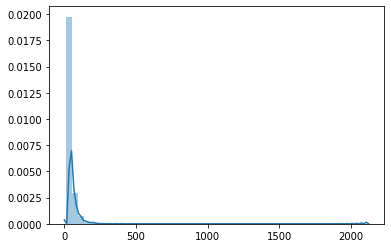

In [8]:
sns.distplot(convo_lens)